# Importing modules, preprocessing


In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [73]:
import io
dataRequired = pd.read_csv('F:/SIH/AustriaNew.csv')
dataRequired.head()

,Unnamed: 0,index,AT_load_actual_entsoe_power_statistics,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal
0,0,87656,7035.0,6343.0,36.0,2.0,109.0,3.27,-4.179,1.5614,25.9639
1,1,87657,7394.0,6882.0,41.0,10.0,146.0,3.23,-2.807,7.5467,75.0443
2,2,87658,7770.0,6963.0,45.0,21.0,146.0,3.22,-1.315,17.2073,116.9171
3,3,87659,7820.0,7110.0,50.0,32.0,158.0,3.22,-0.051,35.4289,146.8923
4,4,87660,7694.0,7136.0,51.0,37.0,187.0,3.00,0.791,58.5238,151.4721


In [74]:
dataRequired.shape

(17488, 11)

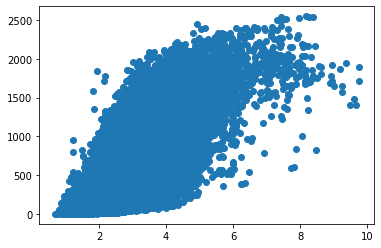

In [75]:
plt.scatter(dataRequired['AT_windspeed_10m'],dataRequired['AT_wind_onshore_generation_actual'])

Here's a plot between the wind speed and wind energy generated. Wind speed is a significant factor as the power output is proportional to it. We can roughly see this trend through the plot which validates that the weather predictions in the data are accurate. The data had quite a bit of deviation about the standard curve. It can be clearly attributed to variations in density of the air density, due to radiation changes throughout the year.

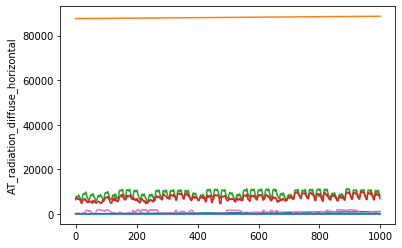

In [76]:
for i in dataRequired:
  plt.ylabel(i)
  plt.plot(dataRequired[i][:1000])

In [77]:
#Converting the time series analysis problem into a supervised learning problem
def seriesToSupervised(data, lookBack = 60, predCols = 1):
  temp = data.copy()
  temp['id'] = range(1, len(temp)+1)
  temp = temp.iloc[: -lookBack, :]
  temp.set_index('id', inplace = True)
  predVal = data.copy()
  predVal = predVal.iloc[lookBack:, predCols]
  predVal.columns = ['Pred']
  predVal = pd.DataFrame(predVal)
  predVal['id'] = range(1, len(predVal)+1)
  predVal.set_index('id', inplace = True)
  finalDf = pd.concat([temp, predVal], axis = 1)
  return finalDf

# Solar energy output forecasting



In [78]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredSolarOutput=dataRequired[['AT_solar_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredSolarOutput['pred'] = dataPredSolarOutput['AT_solar_generation_actual'].shift(-1)
dataPredSolarOutput = dataPredSolarOutput.dropna()
dataPredSolarOutput.head()

C:\Users\Sakshee\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_solar_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,2.0,3.27,-4.179,1.5614,25.9639,10.0
1,10.0,3.23,-2.807,7.5467,75.0443,21.0
2,21.0,3.22,-1.315,17.2073,116.9171,32.0
3,32.0,3.22,-0.051,35.4289,146.8923,37.0
4,37.0,3.00,0.791,58.5238,151.4721,35.0


In [79]:
scalerOne = MinMaxScaler(feature_range=(0,1))
solarScaled = scalerOne.fit_transform(dataPredSolarOutput.values)
solarScaled = pd.DataFrame(solarScaled)

In [80]:
solarScaled.head()

,0,1,2,3,4,5
0,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393
1,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426
2,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459
3,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656
4,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377


In [81]:
arrDfSolar = seriesToSupervised(solarScaled, 3, 0)
arrDfSolar.fillna(0, inplace = True)
arrDfSolar.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.003279,0.285083,0.178747,0.001814,0.064377,0.016393,0.052459
2,0.016393,0.280663,0.209402,0.008767,0.186070,0.034426,0.060656
3,0.034426,0.279558,0.242738,0.019991,0.289892,0.052459,0.057377
4,0.052459,0.279558,0.270980,0.041160,0.364214,0.060656,0.044262
5,0.060656,0.255249,0.289794,0.067990,0.375570,0.057377,0.022951


In [82]:
# splitting and converting the data to right shape, around 80:20 ratio would be good for validation
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [83]:
# We need a 3D data as (sample size, look back steps, input features)
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [84]:
model = Sequential()
model.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
model.add(LSTM(units = 50, return_sequences=True))
model.add(LSTM(units = 30))
model.add(Dense(units = 1))
model.compile(loss = 'mae', optimizer = 'adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 75)             24600     
_________________________________________________________________
lstm_11 (LSTM)               (None, 1, 50)             25200     
_________________________________________________________________
lstm_12 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [85]:
history = model.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 2s 202us/step - loss: 0.0769 - val_loss: 0.0757
Epoch 2/50
11191/11191 [==============================] - 1s 114us/step - loss: 0.0416 - val_loss: 0.0698
Epoch 3/50
11191/11191 [==============================] - 1s 115us/step - loss: 0.0369 - val_loss: 0.0625
Epoch 4/50
11191/11191 [==============================] - 1s 109us/step - loss: 0.0359 - val_loss: 0.0686
Epoch 5/50
11191/11191 [==============================] - 1s 126us/step - loss: 0.0349 - val_loss: 0.0570
Epoch 6/50
11191/11191 [==============================] - 1s 119us/step - loss: 0.0348 - val_loss: 0.0546
Epoch 7/50
11191/11191 [==============================] - 1s 113us/step - loss: 0.0343 - val_loss: 0.0544
Epoch 8/50
11191/11191 [==============================] - 2s 135us/step - loss: 0.0343 - val_loss: 0.0506
Epoch 9/50
11191/11191 [==============================] - 2s 147us/step - loss: 0.0342 - val_loss: 0.05

In [86]:
#Making predictions
yPred = model.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerOne.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerOne.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 16.986655944307604
Mean squared error 786.923685728337
R2_Score 0.9585867722433571


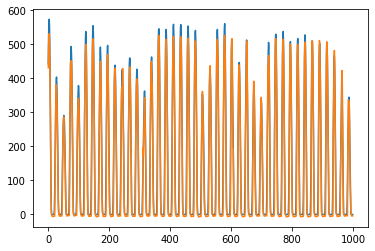

In [87]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

We observe that a 96% R2 score accurate solar energy forecasting is obtained. The graph is plotted between the test and predicted values. Since the solar output peaks during the day and becomes zero at night we see an oscillatory behaviour as depicted by the graph.

# Wind energy output forecasting


In [88]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredWindOutput = dataRequired[['AT_wind_onshore_generation_actual', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredWindOutput['pred'] = dataPredWindOutput['AT_wind_onshore_generation_actual'].shift(-1)
dataPredWindOutput = dataPredWindOutput.dropna()
dataPredWindOutput.head()

C:\Users\Sakshee\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_wind_onshore_generation_actual,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,109.0,3.27,-4.179,1.5614,25.9639,146.0
1,146.0,3.23,-2.807,7.5467,75.0443,146.0
2,146.0,3.22,-1.315,17.2073,116.9171,158.0
3,158.0,3.22,-0.051,35.4289,146.8923,187.0
4,187.0,3.00,0.791,58.5238,151.4721,244.0


In [89]:
scalerTwo = MinMaxScaler(feature_range=(0,1))
windScaled = scalerTwo.fit_transform(dataPredWindOutput.values)
windScaled = pd.DataFrame(windScaled)
windScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [90]:
arrDfWind = seriesToSupervised(windScaled, 3, 0)
arrDfWind.fillna(0, inplace = True)
arrDfWind.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [91]:
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [92]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [93]:
modelOne = Sequential()
modelOne.add(LSTM(128, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelOne.add(LSTM(units = 64, return_sequences=True))
modelOne.add(LSTM(units = 32))
modelOne.add(Dense(units = 1))
modelOne.compile(loss = 'mae', optimizer = 'adam')
modelOne.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 1, 128)            69120     
_________________________________________________________________
lstm_14 (LSTM)               (None, 1, 64)             49408     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [94]:
history = modelOne.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 5s 449us/step - loss: 0.0864 - val_loss: 0.0610
Epoch 2/50
11191/11191 [==============================] - 2s 193us/step - loss: 0.0589 - val_loss: 0.0559
Epoch 3/50
11191/11191 [==============================] - 2s 177us/step - loss: 0.0558 - val_loss: 0.0533
Epoch 4/50
11191/11191 [==============================] - 2s 164us/step - loss: 0.0536 - val_loss: 0.0526
Epoch 5/50
11191/11191 [==============================] - 2s 164us/step - loss: 0.0524 - val_loss: 0.0508
Epoch 6/50
11191/11191 [==============================] - 2s 175us/step - loss: 0.0513 - val_loss: 0.0517
Epoch 7/50
11191/11191 [==============================] - 2s 175us/step - loss: 0.0505 - val_loss: 0.0533
Epoch 8/50
11191/11191 [==============================] - 2s 159us/step - loss: 0.0503 - val_loss: 0.0537
Epoch 9/50
11191/11191 [==============================] - 2s 155us/step - loss: 0.0499 - val_loss: 0.05

In [95]:
#Making predictions
yPred = modelOne.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerTwo.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerTwo.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 107.69218147907283
Mean squared error 28127.905770194055
R2_Score 0.9295016949836353


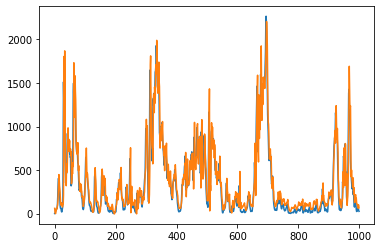

In [96]:
plt.plot(invyTest[:1000])
plt.plot(invyPred[:1000])

Training our model gave us 93% R2 accuracy. The wind energy varies because of a lot of factors, that aren't easily ascertained, windspeed, unlike radiation varies as it varies during the day and cannot be explained. But we can see from the plot that the predicted values have a good accuracy and similar trends.

# Demand forecasting model



In [97]:
#Selecting the feature variables and target variables for a Multivariate LSTM
dataPredDemand = dataRequired[['AT_load_actual_entsoe_power_statistics', 'AT_windspeed_10m', 'AT_temperature', 'AT_radiation_direct_horizontal', 'AT_radiation_diffuse_horizontal']]
dataPredDemand['pred'] = dataPredDemand['AT_load_actual_entsoe_power_statistics'].shift(-1)
dataPredDemand = dataPredDemand.dropna()
dataPredDemand.head()

C:\Users\Sakshee\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,AT_load_actual_entsoe_power_statistics,AT_windspeed_10m,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,pred
0,7035.0,3.27,-4.179,1.5614,25.9639,7394.0
1,7394.0,3.23,-2.807,7.5467,75.0443,7770.0
2,7770.0,3.22,-1.315,17.2073,116.9171,7820.0
3,7820.0,3.22,-0.051,35.4289,146.8923,7694.0
4,7694.0,3.00,0.791,58.5238,151.4721,7565.0


In [98]:
scalerThree = MinMaxScaler(feature_range=(0,1))
demandScaled = scalerThree.fit_transform(dataPredDemand.values)
demandScaled = pd.DataFrame(windScaled)
demandScaled.head()

,0,1,2,3,4,5
0,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277
1,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277
2,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985
3,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362
4,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724


In [99]:
arrDfDemand = seriesToSupervised(demandScaled, 3, 0)
arrDfDemand.fillna(0, inplace = True)
arrDfDemand.head()

,0,1,2,3,4,5,0
id,,,,,,,
1,0.042762,0.285083,0.178747,0.001814,0.064377,0.057277,0.061985
2,0.057277,0.280663,0.209402,0.008767,0.186070,0.057277,0.073362
3,0.057277,0.279558,0.242738,0.019991,0.289892,0.061985,0.095724
4,0.061985,0.279558,0.270980,0.041160,0.364214,0.073362,0.117301
5,0.073362,0.255249,0.289794,0.067990,0.375570,0.095724,0.128286


In [100]:
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
train = values[: trainSample, :]
test = values[trainSample:, :]
XTrain, yTrain = train[:, :-1], train[:, -1]
XTest, yTest = test[:,:-1], test[:, -1]
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 6), (13989,), (3495, 6), (3495,))

In [101]:
XTrain = XTrain.reshape((XTrain.shape[0], 1, XTrain.shape[1]))
XTest = XTest.reshape((XTest.shape[0], 1, XTest.shape[1]))
XTrain.shape, yTrain.shape, XTest.shape, yTest.shape

((13989, 1, 6), (13989,), (3495, 1, 6), (3495,))

In [102]:
modelTwo = Sequential()
modelTwo.add(LSTM(75, return_sequences = True, input_shape = (XTrain.shape[1], XTrain.shape[2])))
modelTwo.add(LSTM(units = 50, return_sequences=True))
modelTwo.add(LSTM(units = 30))
modelTwo.add(Dense(units = 1))
modelTwo.compile(loss = 'mae', optimizer = 'adam')
modelTwo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 1, 75)             24600     
_________________________________________________________________
lstm_17 (LSTM)               (None, 1, 50)             25200     
_________________________________________________________________
lstm_18 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 59,551
Trainable params: 59,551
Non-trainable params: 0
_________________________________________________________________


In [103]:
history = modelTwo.fit(XTrain, yTrain, epochs= 50, batch_size=32, validation_split = 0.2, shuffle = False)

Train on 11191 samples, validate on 2798 samples
Epoch 1/50
11191/11191 [==============================] - 2s 199us/step - loss: 0.0958 - val_loss: 0.0625
Epoch 2/50
11191/11191 [==============================] - 1s 124us/step - loss: 0.0599 - val_loss: 0.0582
Epoch 3/50
11191/11191 [==============================] - 1s 127us/step - loss: 0.0573 - val_loss: 0.0562
Epoch 4/50
11191/11191 [==============================] - 1s 122us/step - loss: 0.0552 - val_loss: 0.0540
Epoch 5/50
11191/11191 [==============================] - 1s 121us/step - loss: 0.0535 - val_loss: 0.0525
Epoch 6/50
11191/11191 [==============================] - 1s 125us/step - loss: 0.0516 - val_loss: 0.0506
Epoch 7/50
11191/11191 [==============================] - 1s 127us/step - loss: 0.0504 - val_loss: 0.0508
Epoch 8/50
11191/11191 [==============================] - 1s 132us/step - loss: 0.0500 - val_loss: 0.0522
Epoch 9/50
11191/11191 [==============================] - 1s 133us/step - loss: 0.0496 - val_loss: 0.05

In [104]:
#Making predictions
yPred = modelTwo.predict(XTest)
XTest = XTest.reshape((XTest.shape[0],XTest.shape[2]))
invyPred = np.concatenate((yPred, XTest[:, 1:]), axis = 1)
invyPred = scalerThree.inverse_transform(invyPred)
invyPred = invyPred[:, 0]

yTest = yTest.reshape((len(yTest), 1))
invyTest = np.concatenate((yTest, XTest[:, 1:]), axis = 1)
invyTest = scalerThree.inverse_transform(invyTest)
invyTest = invyTest[:, 0]

print(f'Mean absolute error {mean_absolute_error(invyTest, invyPred)}')
print(f'Mean squared error {mean_squared_error(invyTest, invyPred)}')
print(f'R2_Score {r2_score(invyTest, invyPred)}')

Mean absolute error 296.75564268633417
Mean squared error 214913.18156245243
R2_Score 0.9298637373026922


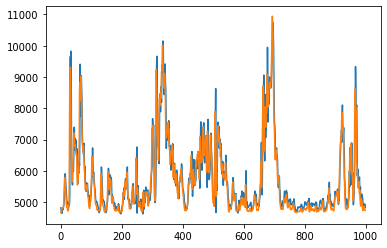

In [105]:
plt.plot(invyPred[:1000])
plt.plot(invyTest[:1000])

Training the model gave a 93% R2 accuracy. As seen from the graph we obtained good prediction accuracy and matching trends.

# The simulation cum forecasting model


In [106]:
#Demand model input
values = arrDfDemand.values
trainSample = int(len(dataPredDemand)*0.8)
testDemand = values[trainSample:, :]
XTestDemand, yTestDemand = testDemand[:,:-1], testDemand[:, -1]
XTestDemand = XTestDemand.reshape((XTestDemand.shape[0], 1, XTestDemand.shape[1]))
XTestDemand.shape, yTestDemand.shape

((3495, 1, 6), (3495,))

In [107]:
#The test demand shall be split into 24 hour intervals:
#yPredDemand = modelTwo.predict(XTestDemand)
#XTestDemand = XTestDemand.reshape((XTestDemand.shape[0],XTestDemand.shape[2]))
#invyPredDemand = np.concatenate((yPredDemand, XTestDemand[:, 1:]), axis = 1)
#invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
#invyPredDemand = invyPredDemand[:, 0]
#yTestDemand = yTestDemand.reshape((len(yTestDemand), 1))
#invyTestDemand = np.concatenate((yTestDemand, XTestDemand[:, 1:]), axis = 1)
#invyTestDemand = scalerThree.inverse_transform(invyTestDemand)
#invyTestDemand = invyTestDemand[:, 0]

In [108]:
#Wind Energy supply
values = arrDfWind.values
trainSample = int(len(dataPredWindOutput)*0.8)
testWind = values[trainSample:, :]
XTestWind, yTestWind = testWind[:,:-1], testWind[:, -1]
XTestWind = XTestWind.reshape((XTestWind.shape[0], 1, XTestWind.shape[1]))
XTestWind.shape, yTestWind.shape

((3495, 1, 6), (3495,))

In [109]:
# #The test wind shall be split into 24 hours
# yPredWind = modelOne.predict(XTestWind)
# XTestWind = XTestWind.reshape((XTestWind.shape[0],XTestWind.shape[2]))
# invyPredWind = np.concatenate((yPredWind, XTestWind[:, 1:]), axis = 1)
# invyPredWind = scalerTwo.inverse_transform(invyPredWind)
# invyPredWind = invyPredWind[:, 0]

# yTestWind = yTestWind.reshape((len(yTestWind), 1))
# invyTestWind = np.concatenate((yTestWind, XTestWind[:, 1:]), axis = 1)
# invyTestWind = scalerTwo.inverse_transform(invyTestWind)
# invyTestWind = invyTestWind[:, 0]

In [110]:
#Solar Energy supply
values = arrDfSolar.values
trainSample = int(len(dataPredSolarOutput)*0.8)
testSolar = values[trainSample:, :]
XTestSolar, yTestSolar = testSolar[:,:-1], testSolar[:, -1]
XTestSolar = XTestSolar.reshape((XTestSolar.shape[0], 1, XTestSolar.shape[1]))
XTestSolar.shape, yTestSolar.shape

((3495, 1, 6), (3495,))

In [111]:
# #The test solar shall be split into 24 hour intervals
# yPredSolar = model.predict(XTestSolar)
# XTestSolar = XTestSolar.reshape((XTestSolar.shape[0],XTestSolar.shape[2]))
# invyPredSolar = np.concatenate((yPredSolar, XTestSolar[:, 1:]), axis = 1)
# invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
# invyPredSolar = invyPredSolar[:, 0]

# yTestSolar = yTestSolar.reshape((len(yTestSolar), 1))
# invyTestSolar = np.concatenate((yTestSolar, XTestSolar[:, 1:]), axis = 1)
# invyTestSolar = scalerOne.inverse_transform(invyTestSolar)
# invyTestSolar = invyTestSolar[:, 0]

In [112]:
XTestSolar.shape, XTestDemand.shape, XTestWind.shape

((3495, 1, 6), (3495, 1, 6), (3495, 1, 6))

In [113]:
def weightMatrix():
  array = []
  for i in range(99):
    array.append(1/(10+5*i))
  array.append(1-sum(array))
  return array

In [114]:
weighs = weightMatrix()
weighs

[0.1,
 0.06666666666666667,
 0.05,
 0.04,
 0.03333333333333333,
 0.02857142857142857,
 0.025,
 0.022222222222222223,
 0.02,
 0.01818181818181818,
 0.016666666666666666,
 0.015384615384615385,
 0.014285714285714285,
 0.013333333333333334,
 0.0125,
 0.011764705882352941,
 0.011111111111111112,
 0.010526315789473684,
 0.01,
 0.009523809523809525,
 0.00909090909090909,
 0.008695652173913044,
 0.008333333333333333,
 0.008,
 0.007692307692307693,
 0.007407407407407408,
 0.007142857142857143,
 0.006896551724137931,
 0.006666666666666667,
 0.0064516129032258064,
 0.00625,
 0.006060606060606061,
 0.0058823529411764705,
 0.005714285714285714,
 0.005555555555555556,
 0.005405405405405406,
 0.005263157894736842,
 0.005128205128205128,
 0.005,
 0.004878048780487805,
 0.004761904761904762,
 0.004651162790697674,
 0.004545454545454545,
 0.0044444444444444444,
 0.004347826086956522,
 0.00425531914893617,
 0.004166666666666667,
 0.004081632653061225,
 0.004,
 0.00392156862745098,
 0.0038461538461538464

In [115]:
for i in range(124):
  XTestSolarHour = XTestSolar[24*i:24*(i+1)]
  XTestWindHour = XTestWind[24*i:24*(i+1)]
  XTestDemandHour = XTestDemand[24*i:24*(i+1)]

In [116]:
#To be called at every 24 hour distribution, generates the demand supply distribution
def dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs):
  #Solar Energy generation
  yPredSolar = model.predict(XTestSolarHour)
  XTestSolarHour = XTestSolarHour.reshape((XTestSolarHour.shape[0],XTestSolarHour.shape[2]))
  invyPredSolar = np.concatenate((yPredSolar, XTestSolarHour[:, 1:]), axis = 1)
  invyPredSolar = scalerOne.inverse_transform(invyPredSolar)
  invyPredSolar = invyPredSolar[:, 0]

  # yTestSolar = yTestSolar.reshape((len(yTestSolar), 1))
  # invyTestSolar = np.concatenate((yTestSolar, XTestSolar[:, 1:]), axis = 1)
  # invyTestSolar = scalerOne.inverse_transform(invyTestSolar)
  # invyTestSolar = invyTestSolar[:, 0]

  #Wind Energy Generation
  yPredWind = modelOne.predict(XTestWindHour)
  XTestWindHour = XTestWindHour.reshape((XTestWindHour.shape[0],XTestWindHour.shape[2]))
  invyPredWind = np.concatenate((yPredWind, XTestWindHour[:, 1:]), axis = 1)
  invyPredWind = scalerTwo.inverse_transform(invyPredWind)
  invyPredWind = invyPredWind[:, 0]

  # yTestWind = yTestWind.reshape((len(yTestWind), 1))
  # invyTestWind = np.concatenate((yTestWind, XTestWind[:, 1:]), axis = 1)
  # invyTestWind = scalerTwo.inverse_transform(invyTestWind)
  # invyTestWind = invyTestWind[:, 0]

  #Demand
  yPredDemand = modelTwo.predict(XTestDemandHour)
  XTestDemandHour = XTestDemandHour.reshape((XTestDemandHour.shape[0],XTestDemandHour.shape[2]))
  invyPredDemand = np.concatenate((yPredDemand, XTestDemandHour[:, 1:]), axis = 1)
  invyPredDemand = scalerThree.inverse_transform(invyPredDemand)
  invyPredDemand = invyPredDemand[:, 0]
    
  # yTestDemand = yTestDemand.reshape((len(yTestDemand), 1))
  # invyTestDemand = np.concatenate((yTestDemand, XTestDemand[:, 1:]), axis = 1)
  # invyTestDemand = scalerThree.inverse_transform(invyTestDemand)
  # invyTestDemand = invyTestDemand[:, 0]

  #Elastic and Inelastic demand
  invyPredDemandInElastic = 0.7*invyPredDemand
  invyPredDemandElastic = 0.3*invyPredDemand
  elasticDemandSum = np.sum(invyPredDemandElastic)

  #Renewable energy output
  renewableEnergyOutput = invyPredSolar + invyPredWind

  #Splitting the above into different prosumers according to a schema, of course in real life, with more computational power
  #One can train separately for each prosumer
  arrayinvyPredDemandInelastic = np.outer(np.array(weighs), np.array(invyPredDemandInElastic))
  arrayRenewableEnergyOutput = np.outer(np.array(weighs), np.array(renewableEnergyOutput))
  arrayElasticDemandSum = np.array(weighs)*elasticDemandSum

  #returns

  return arrayinvyPredDemandInelastic, arrayRenewableEnergyOutput, arrayElasticDemandSum

In [117]:
P, W, E = dataGenerator(XTestSolarHour, XTestWindHour, XTestDemandHour, weighs)
P.shape, W.shape, E.shape

((100, 24), (100, 24), (100,))

In [118]:
np.max(E)

8845.921310069756

In [119]:
EMod = np.hstack([E]*24).reshape((100,24))
EMod.shape

(100, 24)

In [120]:
eMinValues = np.zeros((100, 24))
eMaxValues = EMod/12

In [121]:
#The Scheduling function
from cvxpy import *
def schedulingFunction(PValues, WValues, EValues, eMaxValues, eMinValues):
  e = Variable((100, 24))
  P = Parameter((100, 24))
  W = Parameter((100, 24))
  P.value = PValues
  W.value = WValues
  d = P+e-W
  dSum = sum(d, axis = 0)
  ramp = diff(dSum)
  
  cost = norm(ramp, 'inf')
  obj = Minimize(cost)
  #constraints = [eMinValues <= e, e<= eMaxValues, sum(e) == EValues] # INFEASIBLE
  #constraints = [eMinValues <= e, e<= eMaxValues, sum(e) >= 0.9*EValues]      WORKS!!!!
  constraints = [eMinValues <= e, e<= eMaxValues, sum(e) >= 0.9*EValues]
  prob = Problem(obj, constraints)
  optValue = prob.solve()
  print (prob.status)
  solutionElasticDemand = e.value
  return np.array(solutionElasticDemand)

In [122]:
result = schedulingFunction(P, W, E, 2*eMaxValues, eMinValues)

optimal_inaccurate


In [123]:
print(result)

[[30.32671401 33.67122637 32.27159614 ... 18.53619834 16.82875489
  15.11369182]
 [20.06159734 21.03533092 20.24256393 ... 13.51940083 12.74657913
  11.60500766]
 [13.95516866 14.14974969 13.74125046 ... 10.31535017  9.96798434
   9.15636733]
 ...
 [18.78015339 19.54382536 18.84024172 ... 12.88492933 12.21000739
  11.13292279]
 [13.22834848 13.37116964 13.00247474 ...  9.90106844  9.59492354
   8.82782989]
 [ 9.95428025  9.96670156  9.75798797 ...  7.920999    7.76630255
  19.81949735]]


**RAMPING OF SUPPLY OF GENERATORS USING CONVENTIONAL SOURCES** 

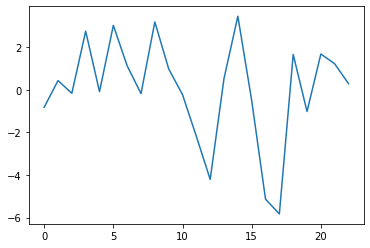

In [124]:
plt.plot(np.diff(np.array(P+result-W)[10]))

**INELASTIC DEMAND**

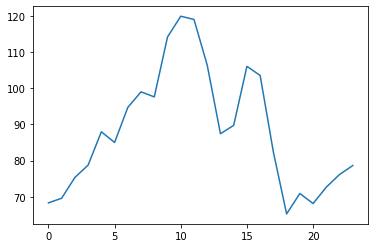

In [125]:
plt.plot(P[10])

**ELASTIC DEMAND ALLOCATED**

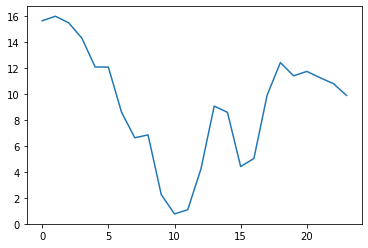

In [126]:
plt.plot(result[10])

**POWER SUPPLIED BY CONVENTIONAL SOURCES**

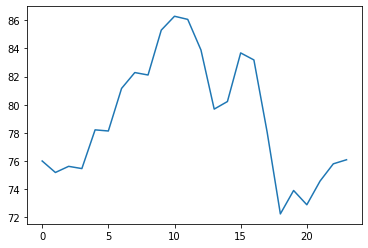

In [127]:
plt.plot((P+result-W)[10])

**RENEWABLE ENERGY SUPPLIED**

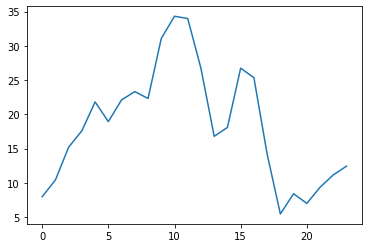

In [128]:
plt.plot(W[10])

#### INELASTIC DEMAND OF THE FIRST 20 PROSUMERS OVER 24 HOURS

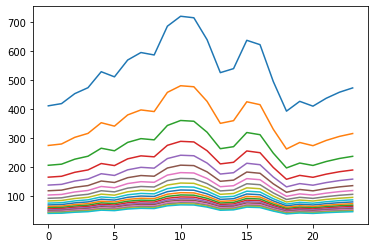

In [129]:
for i in range(20):
  plt.plot(P[i])

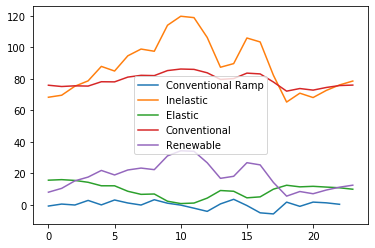

In [130]:
plt.plot(np.diff(np.array(P+result-W)[10]))
plt.plot(P[10])
plt.plot(result[10])
plt.plot((P+result-W)[10])
plt.plot(W[10])
plt.legend(['Conventional Ramp', 'Inelastic', 'Elastic', 'Conventional', 'Renewable'])